# Necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import random
import os
import splitfolders
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras.models import load_model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tifffile import imsave
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()

# Dataloader

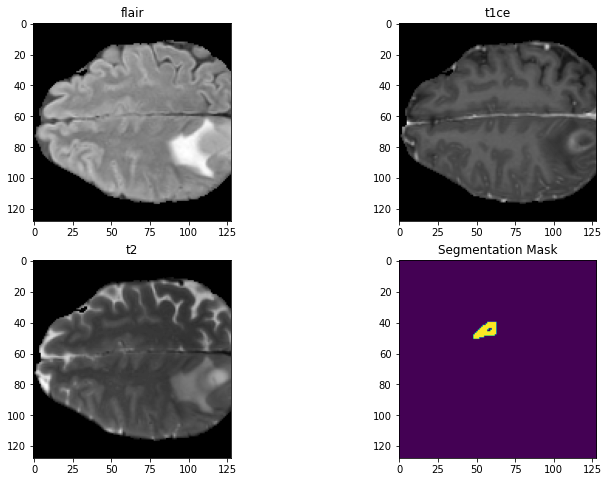

In [2]:
def load_img(img_dir, images_list):
    images=[]
    for i, image_name in enumerate(images_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, images_list, mask_dir, mask_list, batch_size):

    L = len(images_list)
 
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, images_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)     

            batch_start += batch_size   
            batch_end += batch_size



training_data_path_images = "BraTS2020_TrainingData/input_data_128/train/images/"
training_data_path_masks = "BraTS2020_TrainingData/input_data_128/train/masks/"
training_images_list=os.listdir(training_data_path_images)
training_masks_list = os.listdir(training_data_path_masks)

batch_size = 2

training_images_datagenerator = imageLoader(training_data_path_images, training_images_list, 
                                training_data_path_masks, training_masks_list, batch_size)


img, msk = training_images_datagenerator.__next__()


num = random.randint(0,img.shape[0]-1)
test_img=img[num]
test_seg_mask=msk[num]
test_seg_mask=np.argmax(test_seg_mask, axis=3)

n_slice=random.randint(0, test_seg_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('t2')
plt.subplot(224)
plt.imshow(test_seg_mask[:,:,n_slice])
plt.title('Segmentation Mask')
plt.show()

# U-net model

In [4]:

kernel_initializer =  'he_uniform'

def unet_model(height, width, depth, channels, num_classes):
    inputs = Input((height, width, depth, channels))
    input_s = inputs

    #Encoder
    c_1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(input_s)
    c_1 = Dropout(0.1)(c_1)
    c_1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c_1)
    p_1 = MaxPooling3D((2, 2, 2))(c_1)
    
    c_2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p_1)
    c_2 = Dropout(0.1)(c_2)
    c_2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c_2)
    p_2 = MaxPooling3D((2, 2, 2))(c_2)
     
    c_3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p_2)
    c_3 = Dropout(0.2)(c_3)
    c_3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c_3)
    p_3 = MaxPooling3D((2, 2, 2))(c_3)
     
    c_4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p_3)
    c_4 = Dropout(0.2)(c_4)
    c_4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c_4)
    p_4 = MaxPooling3D(pool_size=(2, 2, 2))(c_4)
     
    c_5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p_4)
    c_5 = Dropout(0.3)(c_5)
    c_5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c_5)

    #Decoder
    u_6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c_5)
    u_6 = concatenate([u_6, c_4])
    c_6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u_6)
    c_6 = Dropout(0.2)(c_6)
    c_6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c_6)
     
    u_7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c_6)
    u_7 = concatenate([u_7, c_3])
    c_7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u_7)
    c_7 = Dropout(0.2)(c_7)
    c_7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c_7)
     
    u_8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c_7)
    u_8 = concatenate([u_8, c_2])
    c_8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u_8)
    c_8 = Dropout(0.1)(c_8)
    c_8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c_8)
     
    u_9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c_8)
    u_9 = concatenate([u_9, c_1])
    c_9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u_9)
    c_9 = Dropout(0.1)(c_9)
    c_9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c_9) 

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c_9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model
 
model = unet_model(128, 128, 128, 3, 4)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_1 (Conv3D)              (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d_1[0][0]']               
                                8, 16)                                                      

                                                                                                  
 conv3d_13 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_1[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_6 (Dropout)            (None, 32, 32, 32,   0           ['conv3d_13[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_14 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_6[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_tr

In [3]:
#training
#images and masks are 128x128x128x3
training_data_path_images = "BraTS2020_TrainingData/input_data_128/train/images/"
training_data_path_masks = "BraTS2020_TrainingData/input_data_128/train/masks/"

images_list = os.listdir(training_data_path_images)
masks_list = os.listdir(training_data_path_masks)

image_count = len(os.listdir(training_data_path_images))

#Define the image generators for training and validation

training_data_path_images = "BraTS2020_TrainingData/input_data_128/train/images/"
training_data_path_masks = "BraTS2020_TrainingData/input_data_128/train/masks/"

validation_data_path_images = "BraTS2020_TrainingData/input_data_128/val/images/"
validation_data_path_masks = "BraTS2020_TrainingData/input_data_128/val/masks/"
 
training_images_list=os.listdir(training_data_path_images)
training_masks_list = os.listdir(training_data_path_masks)

validation_images_list=os.listdir(validation_data_path_images)
validation_masks_list = os.listdir(validation_data_path_masks)

#training
batch_size = 2
training_images_datagenerator = imageLoader(training_data_path_images, training_images_list, 
                                training_data_path_masks, training_masks_list, batch_size)

validation_images_datagenerator = imageLoader(validation_data_path_images, validation_images_list, 
                                validation_data_path_masks, validation_masks_list, batch_size)

In [6]:
#Define loss, metrics and optimizer to be used for training
import segmentation_models_3D as sm
import tensorflow as tf
dice_l = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) #dice loss
focal_l = sm.losses.CategoricalFocalLoss() 

#focal loss
total_l = dice_l + (1 * focal_l) #total loss
cce = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
LR = 0.0001
model_optimizer = Adam(LR)


#Fitting the model
steps_per_epoch = len(training_images_list)//batch_size
val_steps_per_epoch = len(validation_images_list)//batch_size


model = unet_model(height=128, 
                          width=128, 
                          depth=128, 
                          channels=3, 
                          num_classes=4)

model.compile(optimizer = model_optimizer, loss=cce, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(training_images_datagenerator,
          steps_per_epoch=steps_per_epoch,
          epochs=4,
          verbose=1,
          validation_data=validation_images_datagenerator,
          validation_steps=val_steps_per_epoch,
          )

Segmentation Models: using `tf.keras` framework.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_20 (Conv3D)             (None, 128, 128, 12  1312        ['input_3[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_20[0][0]']              
                                8, 16)     

                                                                                                  
 conv3d_32 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_5[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_15 (Dropout)           (None, 32, 32, 32,   0           ['conv3d_32[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_33 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_15[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr

                                64)                                                               
                                                                                                  
 max_pooling3d_6 (MaxPooling3D)  (None, 16, 16, 16,   0          ['conv3d_25[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_26 (Conv3D)             (None, 16, 16, 16,   221312      ['max_pooling3d_6[0][0]']        
                                128)                                                              
                                                                                                  
 dropout_12 (Dropout)           (None, 16, 16, 16,   0           ['conv3d_26[0][0]']              
                                128)                                                              
          

 conv3d_37 (Conv3D)             (None, 128, 128, 12  6928        ['dropout_17[0][0]']             
                                8, 16)                                                            
                                                                                                  
 conv3d_38 (Conv3D)             (None, 128, 128, 12  68          ['conv3d_37[0][0]']              
                                8, 4)                                                             
                                                                                                  
Total params: 5,645,828
Trainable params: 5,645,828
Non-trainable params: 0
__________________________________________________________________________________________________
None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)
Epoch 1/4
129/129 [==============================] - 5224s 40s/step - loss: 0.4197 - accuracy: 0.8944 - iou_score: 0.2099 - val_loss: 0.2545 - val_accuracy: 0.9503 - val_iou_sc

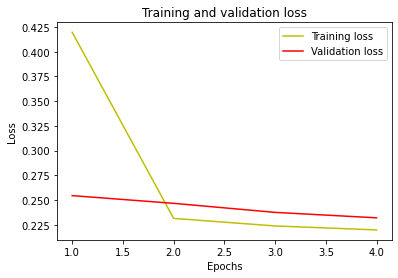

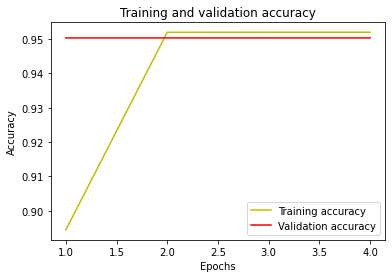

In [7]:

model.save('brats_UNET.hdf5')

#plotting training and val IoU and loss for each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
import segmentation_models_3D as sm
import tensorflow as tf
dice_l = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) #dice loss
focal_l = sm.losses.CategoricalFocalLoss() 

#focal loss
total_l = dice_l + (1 * focal_l) #total loss
cce = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
LR = 0.0001
model_optimizer = Adam(LR)
my_model = load_model('brats_UNET.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_l,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

Segmentation Models: using `tf.keras` framework.


In [ ]:
#Adding IOU Score
my_model = load_model('brats_UNET.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_l,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Continue training process
history2=my_model.fit(training_images_datagenerator,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=validation_images_datagenerator,
          validation_steps=val_steps_per_epoch,
          )

In [ ]:
my_model.save('brats_UNET.hdf5')

# Prediction

Mean IoU = 0.8371573239564896


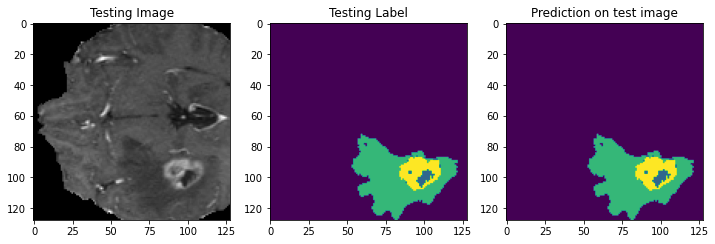

In [5]:
my_model = load_model('brats_UNET.hdf5', 
                      compile=False)


batch_size=8 
test_img_datagen = imageLoader(validation_data_path_images, validation_images_list, 
                                validation_data_path_masks, validation_masks_list, batch_size)


test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())



img_num = 82
test_img = np.load("./BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("./BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]



n_slice = 46
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
test_prediction_argmax = test_mask_argmax
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()